<a href="https://colab.research.google.com/github/JuanesGuarin/grasping-project/blob/main/grasping_GUARIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Data
Download the Cornell data on the website https://github.com/LaurentBimont/process_Cornell
Clone the files and install them on your system

In [75]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
from google.colab import files, drive
drive.mount('/content/drive/')



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd ~
%cd ..
%cd content/drive/MyDrive/Colab Notebooks/grasping-project
%pwd
%ls -la
## Conect to my worksapce

folder_path = os.getcwd()  # Get path
folder_name = 'process_Cornell-master'  # Get name of folder to search my files
folder_path_1 = os.path.join(folder_path, folder_name) # Add to my path
print(folder_path_1) # Visualize my path

folder_name_f = 'x_split/' # Name of file to iterate later :)
folderpath_file=os.path.join(folder_path_1, folder_name_f) # Add to my path again
print(folderpath_file)


X = [] # List to save my data

for file_num in range(len(os.listdir(folderpath_file))):
  X.extend(np.load(folderpath_file + 'x_{}.npy'.format(file_num))) # Save data in arrays

X = np.array(X)
Y = np.load(folder_path_1 + '/all_Y_test_format.npy', allow_pickle=True) # Save Y data in other variable
Y = np.array([np.array(y) for y in Y])

print(Y[1])


/root
/
/content/drive/MyDrive/Colab Notebooks/grasping-project
total 17518
-rw------- 1 root root  1227873 Aug  6 19:24 grasping_GUARIN.ipynb
-rw------- 1 root root 16705832 Aug  6 19:21 model_1.3.weights.h5
drwx------ 3 root root     4096 Aug  6 19:09 process_Cornell-master/
/content/drive/MyDrive/Colab Notebooks/grasping-project/process_Cornell-master
/content/drive/MyDrive/Colab Notebooks/grasping-project/process_Cornell-master/x_split/


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (750,) + inhomogeneous part.

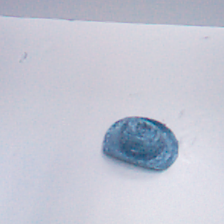

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(X[399])

# Representation of the data
For the grasping representation we use 5 grasping parameters: x, y, $\theta$, w et h.
In the following, we will try to predict them with a neural network.

![Texte alternatif…](https://miro.medium.com/max/774/1*qG24SN9X3LqMrnz_Fb_t6w.png)

There are several things to note:

For an image there are several possible grasping parameters:
* The variable y_train contains all possible grasping rectangles. So it's a list list for example: $$[(x_1, y_1, \theta_1, w_1, h_1), (x_2, y_2, \theta_2, w_2, h_2), (x_3, y_3, \theta_3, w_3, h_3)] $$

* Consideration should be given to how to use y_train to effectively train a network. To view the rectangles on an image using python, you have to convert these grasping parameters into a rectangle representation (the coordinates of the 4 sides). To move from one to the other one has the functions 'bboxes_to_grasps' and 'grasp_to_bbox'.

* The 'vizualise' function allows grasping rectangles to be displayed on an image. The green lines represent the location of the robotic grasp.

* To determine if a prediction is correct, the Jacquard metric, also known as IoU (Intersection over Union), is used. Consider a rectangle of grasping predicts $\mathcal{R}_{pred}$ and the true $\mathcal{R}_{true}$, the intersection on the union of these rectangles must be greater than 0.25: $$\frac{\mathcal{R}_{true}\cap\mathcal{R}_{pred}}{\mathcal{R}_{true}\cup\mathcal{R}_{pred}}$$ In addition, the angle difference should be less than 30 degrees. The 'performance' function performs this test.






In [ ]:
print('Input dimensions: ', X.shape)
print('Output dimensions: ', Y.shape)
print('First element of Y', Y[0])

Input dimensions:  (750, 224, 224, 3)
Output dimensions:  (750,)
First element of Y [(139.8095238095238, 125.6998095238095, np.float64(84.8055710922652), np.float64(25.188990864482342), np.float64(54.970641549327695)), (121.9047619047619, 121.73942857142855, np.float64(81.31588231648558), np.float64(26.183375660860307), np.float64(60.554014177108414)), (104.0, 119.2624761904762, np.float64(84.8055710922652), np.float64(22.869837744462686), np.float64(70.18123129295981))]


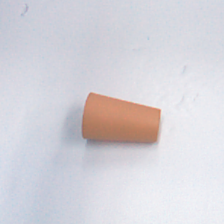

In [ ]:
cv2_imshow(X[0])

# Fonctions utiles

In [ ]:
## Draw the grasping rectangles on an  image --- Reality
def draw_rectangle(mes_rectangles, image):
  '''
  mes_rectangles is a list of 4 points of a rectangle
  image is a numpy array where we draw the grasping rectangles
  '''
  for rectangle in mes_rectangles:
      point1, point2 = tuple([int(float(point)) for point in rectangle[0]]), tuple(
          [int(float(point)) for point in rectangle[1]])
      point3, point4 = tuple([int(float(point)) for point in rectangle[2]]), tuple(
          [int(float(point)) for point in rectangle[3]])
      cv2.line(image, point1, point2, color=(0, 0, 255), thickness=1)
      cv2.line(image, point3, point4, color=(0, 0, 255), thickness=1)
      cv2.line(image, point2, point3, color=(0, 255, 0), thickness=2)
      cv2.line(image, point4, point1, color=(0, 255, 0), thickness=2)
  return image


def vizualise(x, y):
  '''
  x : is a raw image
  y : is a list of lists with the grasping parameters

  even if you visualize only one grasping parameter,
  there must be a list of list
  '''
  tot_rect = []
  for box in y:
    if box[0]<500:
      rect = grasp_to_bbox(box)
      rect = [float(item) for vertex in rect for item in vertex]
      grasp = bboxes_to_grasps(rect)
      new_rect = grasp_to_bbox(grasp)
      tot_rect.append(new_rect)
  image = draw_rectangle(tot_rect, x)
  plt.imshow(image)
  plt.title('grasping rectangles')


#### Drawing recatbgles for prediction

def vizualise_p(x, y):
  '''
  x : is a raw image
  y : is a list of lists with the grasping parameters

  even if you visualize only one grasping parameter,
  there must be a list of list
  '''
  tot_rect = []
  for box in y:
    if box[0]<500:
      rect = grasp_to_bbox(box)
      rect = [float(item) for vertex in rect for item in vertex]
      grasp = bboxes_to_grasps(rect)
      new_rect = grasp_to_bbox(grasp)
      tot_rect.append(new_rect)
  image = draw_rectangle_p(tot_rect, x)
  plt.imshow(image)
  plt.title('grasping rectangles')


def draw_rectangle_p(mes_rectangles, image):
  '''
  mes_rectangles is a list of 4 points of a rectangle
  image is a numpy array where we draw the grasping rectangles
  '''
  for rectangle in mes_rectangles:
      point1, point2 = tuple([int(float(point)) for point in rectangle[0]]), tuple(
          [int(float(point)) for point in rectangle[1]])
      point3, point4 = tuple([int(float(point)) for point in rectangle[2]]), tuple(
          [int(float(point)) for point in rectangle[3]])
      cv2.line(image, point1, point2, color=(255, 0, 0), thickness=1)
      cv2.line(image, point3, point4, color=(255, 0, 0), thickness=1)
      cv2.line(image, point2, point3, color=(0, 255, 0), thickness=2)
      cv2.line(image, point4, point1, color=(0, 255, 0), thickness=2)
  return image


def bboxes_to_grasps(box):
  '''
  convert a rectangle into the grasping parameters
  '''
  x = (box[0] + (box[4] - box[0])/2)
  y = (box[1] + (box[5] - box[1])/2)
  if box[0] == box[2]:
      tan = 30
  else:
      tan = -(box[3] - box[1]) / (box[2] - box[0])
  tan = max(-11, min(tan, 11))
  w = np.sqrt(np.power((box[2] - box[0]), 2) + np.power((box[3] - box[1]), 2))
  h = np.sqrt(np.power((box[6] - box[0]), 2) + np.power((box[7] - box[1]), 2))
  angle = np.arctan(tan) * 180/np.pi
  return x, y, angle, h, w


def grasp_to_bbox(grasp):
  '''
  convert the grasping parameters into a rectangle
  '''
  x, y, theta, h, w = tuple(grasp)
  theta = theta * np.pi/180
  edge1 = [x - w/2*np.cos(theta) + h/2*np.sin(theta), y + w/2*np.sin(theta) + h/2*np.cos(theta)]
  edge2 = [x + w/2*np.cos(theta) + h/2*np.sin(theta), y - w/2*np.sin(theta) + h/2*np.cos(theta)]
  edge3 = [x + w/2*np.cos(theta) - h/2*np.sin(theta), y - w/2*np.sin(theta) - h/2*np.cos(theta)]
  edge4 = [x - w/2*np.cos(theta) - h/2*np.sin(theta), y + w/2*np.sin(theta) - h/2*np.cos(theta)]
  return [edge1, edge2, edge3, edge4]


from shapely.geometry import Polygon

def performance(Y_pred, Y_true):
  '''
  Y_pred and Y_true are the two grasping parameters
  '''
  grasp_pred = grasp_to_bbox(Y_pred)
  grasp_true = grasp_to_bbox(Y_true)

  p_pred = Polygon(grasp_pred)
  p_true = Polygon(grasp_true)

  iou = p_pred.intersection(p_true).area / (p_pred.area + p_true.area - p_pred.intersection(p_true).area)
  theta_pred, theta_true = Y_pred[2], Y_true[2]
  if iou > 0.25 and (np.abs(theta_pred-theta_true) < 30 or np.abs(theta_pred % 180-theta_true % 180)):
      return True
  else:
      return False

(224, 224, 3)


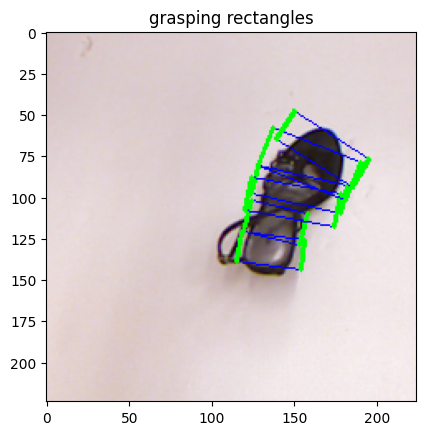

In [ ]:
n = np.random.randint(500)
vizualise(X[1], Y[1])
print(X[n].shape)

# Build your first network for the grasping prediction
For this you must:

*   Define a network architecture
*   Define a regression loss function
*   Define a Y format well adaptated (the current format is not adaptated)
*   Set a function to evaluate the number of successfull grasping on the test data test place une fonction pour déterminer le nombre de grasping (you have to reach a success rate of 40-50%)

### Architecture + Loss function
Complete the following function with layers, compilation method and suitable loss function


*   Test of different architectures
*   Choose an optimizer (https://keras.io/optimizers/)
*   Choose a loss function suitable for regression (https://keras.io/losses/)

NB: you can use "transfer learning"





In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization

def model_1(input_shape):
  model = Sequential()
  model.add(Conv2D(96, (5,5), 2, activation='relu', input_shape=(224, 224, 3)))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
  model.add(BatchNormalization())

  model.add(Conv2D(128, (3,3), 2, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
  model.add(BatchNormalization())

  model.add(Conv2D(128, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(BatchNormalization())

  model.add(Conv2D(512, (3,3), 2, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(BatchNormalization())

  # model.add(Conv2D(256, (3,3), 2, activation='relu'))
  # model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(5, activation='relu'))
  model.compile(loss='mean_absolute_error',
                  optimizer='Nadam',
                  metrics=['accuracy'])
  model.summary()
  return model

input_shape = (224, 224, 3)
model0 = model_1(input_shape)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 110, 110, 96)   │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 55, 55, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 27, 27, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 13, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 11, 11, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 2, 2, 512)      │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 1, 1, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,387,269 (5.29 MB)

 Trainable params: 1,385,541 (5.29 MB)

 Non-trainable params: 1,728 (6.75 KB)

### Training
Prepare the data so that you can train your network.

*   Separate your data in train / test thanks to the function: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

*   The Y has the following format: (number of photos, number of possible graspings, 5). However, to function correctly, Y must be in the format (nb photo, 5). Y must therefore be reworked by selecting only one grasping parameter among all those possible. Do this by selecting only the first parameter of grasping for example.

* Train your model by choosing a batch_size and the number of epochs

Remarks:

* you are free to set up callbacks or other functions to improve your network

* You are also free to view the training history to analyze what happened and suggest improvements to your network

* You are free to use transfer learning or not.

* Do not use data augmentation, we will do it after



In [ ]:
## Data preparation
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
# (Xtrain, Ytrain), (Xtest, Ytest) = mnist.load_data()
# To avoid having to reload data all the time, make a copy of the original data
X1, Y1 = np.copy(X), np.copy(Y)


#### Data separation into x_train, y_train
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.35, random_state=40)


y_test_copie = np.copy(y_test)    # We keep a y_test in the initial format

### Give Y an acceptable format ()
y_train = np.array([np.array(y[0], dtype = np.float64) for y in y_train])
y_test = np.array([np.array(y[0],dtype = np.float64) for y in y_test])
# test should return (something, 5)
print('test', y_train.shape)

print('shape xtrain=',x_train.shape)
print('shape ytrain=',y_train.shape)
print('shape xtest=',x_test.shape)
print('shape ytest=',y_test.shape)


test (487, 5)
shape xtrain= (487, 224, 224, 3)
shape ytrain= (487, 5)
shape xtest= (263, 224, 224, 3)
shape ytest= (263, 5)


In [ ]:
## Training
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import optimizers
import keras
print("Modelo: ", model0)
history = model0.fit(x_train,y_train, batch_size=50,epochs=120,verbose=1,validation_data=(x_test,y_test) )


Modelo:  <Sequential name=sequential_3, built=True>
Epoch 1/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 789ms/step - accuracy: 0.0864 - loss: 62.5488 - val_accuracy: 0.3118 - val_loss: 175.4527
Epoch 2/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5103 - loss: 35.5876 - val_accuracy: 0.6882 - val_loss: 432.3723
Epoch 3/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6511 - loss: 24.2888 - val_accuracy: 0.6882 - val_loss: 1477.8116
Epoch 4/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7018 - loss: 22.5619 - val_accuracy: 0.6882 - val_loss: 1445.6095
Epoch 5/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6995 - loss: 20.8010 - val_accuracy: 0.6882 - val_loss: 988.4313
Epoch 6/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7370 - loss: 19.9096 - val_accuracy: 0.6882 - val_loss: 989.4109
Epoch 7/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7656 - loss: 20.1234 - val_accuracy: 0.6882 - val_loss: 435.6305
Epoch 8/120
10/10 ━━━━━━━━━

Once you have obtained a satisfactory model, you can save it so that you do not have to retrain it each time.

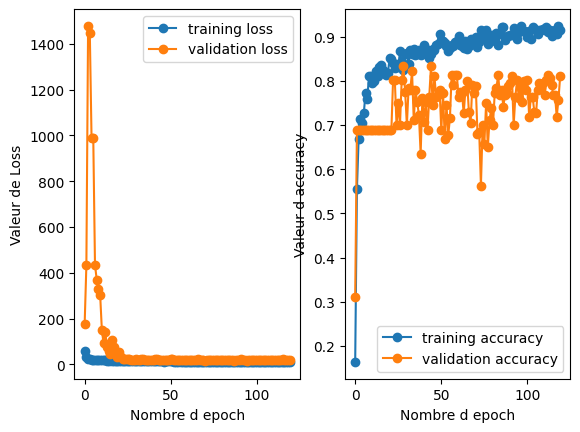

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='o', label='training loss')
plt.plot(history.history['val_loss'], marker='o', label='validation loss')
plt.xlabel('Nombre d epoch')
plt.ylabel('Valeur de Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], marker='o', label='training accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='validation accuracy')
plt.xlabel('Nombre d epoch')
plt.ylabel('Valeur d accuracy')
plt.legend()
plt.show()

In [ ]:
_, acc = model0.evaluate(x_test,y_test)
print('> %.3f' % (acc * 100.0))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.8223 - loss: 16.6945
> 80.989


In [ ]:
import keras
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
#Prediction sur les donnés de test et matrice de confusion
y_pred=model0.predict(x_test)
Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
print(Y_pred)
print(y_pred[0])


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
[0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1
 0 0 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1
 0 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 0
 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0
 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0
 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1
 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 1]
[154.43008 146.84424   0.       20.23503  32.03523]


In [ ]:
## Save the weights of your model
## To load a previously trained model (that of the final model or that of a checkpoint)
model0.save_weights('model_1.3.weights.h5')
## To load a previously trained model (that of the final model or that of a checkpoint)
model0.load_weights('model_1.3.weights.h5')

## Performance
Evaluating the exact capacities of your network is essential to be able to improve it as you go. The value of the loss function is not very meaningful, so we need to develop our own metric.

Here we are going to write two functions allowing to know the successful grasping rate and to visualize a prediction of our model.


### Write a function to test the performance of my network
This function should make it possible to return the success rate of the predictions of a model.
As input, it will receive y_pred in format (number of photos, 5) and y_test_copie in format (number of photos, number of possible grasp, 5). Be careful not to count several admissible graspings of the same photo!

On output, it will return the number of good predictions divided by the total number of predictions.

You are going to need **performance()**





In [ ]:
print(y_pred[0])
print(y_test_copie[0])

[154.43008 146.84424   0.       20.23503  32.03523]
[(160.76190476190476, 98.91504761904761, np.float64(-10.944123338589772), np.float64(24.057376615385817), np.float64(29.488697808942316)), (159.23809523809524, 107.02780952380951, np.float64(-5.931602427953986), np.float64(22.21315007560112), np.float64(29.874233288352226)), (156.95238095238093, 120.75238095238095, np.float64(-4.119546851436072), np.float64(21.38768586303725), np.float64(32.082891506808444)), (153.9047619047619, 138.3390476190476, np.float64(-3.5577232895420914), np.float64(24.428525016200208), np.float64(35.11529366861547))]


Play a little, visualize some images :)

Array prediction:  [array([131.80453 , 144.79486 ,   0.      ,  19.147552,  30.58333 ],
      dtype=float32)]
Array test:  [array([107.04761905, 117.16114286, -20.78322676,  13.01943428,
        13.85385707])]


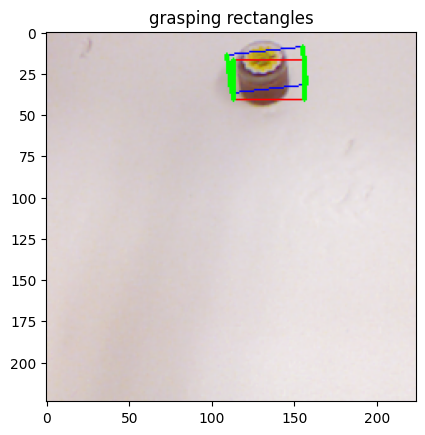

In [ ]:
y_vis=[[x] for x in y_test]
y_vis_pre=[[x] for x in y_pred]
print("Array prediction: ", y_vis_pre[1])
print("Array test: ", y_vis[1] )
vizualise(x_test[86], y_vis[86])
vizualise_p(x_test[86], y_vis_pre[86])

In [ ]:
def test_performance(y_pred, y_test):
  pred=0
  for i in range(len(y_pred)):
    for j in range(len(y_test[i])):
      if performance(y_pred[i], y_test[i][j]):
        pred+=1
        break
  result=pred/len(y_pred)
  return(result)

### Look into our performance:
y_pred = model0.predict(x_test)
print('Performance of my trained model : {:.1%}'.format(test_performance(y_pred, y_test_copie)))

### Not bad for our first model, we looking for a better performance

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Performance of my trained model : 63.1%


###  Write a function to view a prediction of my network
model is a deep learning model and x is an image on which we have to calculate the prediction

Make this function display an image with the predicted rectangle materialized on it.

Write yourself a script to test this function

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


()

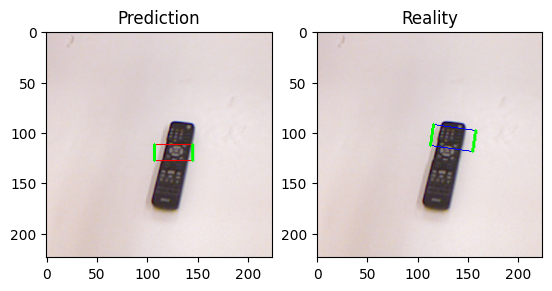

In [ ]:
def show_prediction(model, x, y):
  y=[[x] for x in y]
  n = np.random.randint(0,len(x))
  y_pred_v = model.predict(x)
  plt.subplot(1, 2, 1)
  vizualise_p(np.array(x[n]), [y_pred[n]]) # I create other function with the same strcuture for change color and see what happen with my pred
  plt.title("Prediction")
  plt.subplot(1, 2, 2)
  vizualise(np.array(x[n]), y[n])
  plt.title("Reality")
  return()

show_prediction(model0,x_test,y_test)

So here is a first network which should be able to easily reach 50% success.

To improve the accuracy of the network, we will act on two levers:

* Write a custom loss function to take into account the initial y
* Increase the amount of data available using data augmentation




## Define your own Loss Function
The y format is $g_{true} = [(x_1, y_1, \theta_1, w_1, h_1), (x_2, y_2, \theta_2, w_2, h_2), (x_3, y_3, \theta_3, w_3, h_3)] $.
Previously, we decided to compare the output of the network $g_{pred}=(x, y, \theta, w, h)$ to only the first possible grasping rectangle $g = [(x_1, y_1, \theta_1, w_1, h_1)]$ to train the network with a loss function $\mathcal{L}$ of your choice:
$$\mathcal{L}(g, g_{pred})$$


To take into account all the possible grasping rectangles, and hopefully improve training, we will use another loss function:

$$ \mathcal{L}_{new}(g_{true}, g_{pred}) = \min_{g\in g_{true}} \mathcal{L}(g, g_{pred})$$

This function is not canonical and we will have to write it by ourselves. Keras allows this, here is how canonical functions are defined (https://github.com/keras-team/keras/blob/master/keras/losses.py
from line 602). We will therefore imitate them.

Several remarks:
* This function will be called internally in keras, it is necessary to use keras functions to do the mathematical operations on the variables y_pred, y_true (they are of type tensor). Instead of np.sum or np.min, we will use K.sum or K.min.
* Keras doesn't really like having Ys with changing shapes (as a reminder: (nb of photos, nb of possible grasp, 5)) we will therefore reformat all the ys so that they all have the same shape: (nb of photos, 40, 5). It will therefore be necessary to artificially add graspings to most y while ensuring that they do not affect the loss function. In fact, we will add $ [1000, 1000, 1000, 1000, 1000] $ grasping parameters that have no chance of being a minimum. We will therefore have a new y of the form:
$$g_{new,true} = [(x_1, y_1, \theta_1, w_1, h_1), (x_2, y_2, \theta_2, w_2, h_2), (x_3, y_3, \theta_3, w_3, h_3), ..., (1000, 1000, 1000, 1000, 1000)] $$


Reformat the Y.

Y is of size (750,) and contains different numbers of elements on its axis 1 (this is why no dimension is specified).
Add graspings [1000, 1000, 1000, 1000, 1000] so that all images have 40 possible graspings.
The function will return a numpy array


In [ ]:
def preprocess_data_min_mse(Y):
    num_grasps = 40
    default_grasp = [1000, 1000, 1000, 1000, 1000]
    # Fill with this array and have a "normalization of our data"
    filled_Y = []
    for image_grasps in Y:
        filled_Y.extend(image_grasps)
        num_missing_grasps = num_grasps - len(image_grasps)
        filled_Y.extend([default_grasp] * num_missing_grasps)
    reshaped_Y = np.array(filled_Y).reshape((len(Y), num_grasps, -1)) # Transform to numpy
    return reshaped_Y
#### Test : It must show: (750, 224, 224, 3) (750, 40, 5)(750,)
y11 = np.copy(Y)
yy = preprocess_data_min_mse(y11)
print(yy.shape,Y.shape)

(750, 40, 5) (750,)


In [ ]:
print(Y.shape)

(750,)


Now let's write the loss function. Be inspired by canonical functions. I am giving you the first line of the cost function which changes the format of y_pred (to y_pred_temp) to be able to apply our cost function. Its shape is: $g_{pred, temp} = [(x, y, \theta, w, h), (x, y, \theta, w, h), (x, y, \theta, w, h), ...,(x, y, \theta, w, h)]$

*   y_pred : (batch_size, 5)
*   y_true : (batch_size, nb_of_possible_grasping_area, 5)
*   y_pred_temp : (batch_size, nb_of_grasping_areas, 5) with the same prediction iterated x times

You can use K.square, K.abs, K.mean, K.min according your loss function. As  numpy, you can set which axis you can evaluate.

In [ ]:
# Implement it: only 5 lines of code,
import tensorflow as tf
import tensorflow.keras.backend as K

def myFunction(y_true, y_pred):
    y_pred_temp = K.repeat(y_pred, K.shape(y_true)[1])
    res = K.mean(K.square(y_true - y_pred_temp), axis=[1,2])
    return res

#  Test : by running the test below, you should get:
# [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
# 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
# 1. 1.]
y_true = tf.zeros((50, 20, 5))
y_pred = tf.ones((50, 5))
A = myFunction(y_true, y_pred)
#with tf.Session() as sess:
    #print(A.eval())
print(A.numpy())

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


Recreate your model using your cost function

In [ ]:
def model_2(input_shape):
  model = Sequential()
  model.add(Conv2D(96, (5,5), 2, activation='relu', input_shape=(224, 224, 3)))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
  model.add(BatchNormalization())

  model.add(Conv2D(64, (3,3), 2, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
  model.add(BatchNormalization())

  model.add(Conv2D(64, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(BatchNormalization())

  model.add(Conv2D(512, (3,3), 2, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='relu'))
  model.compile(optimizer='Nadam',loss=myFunction)

  model.summary()
  return model

input_shape = (224, 224, 3)
model2 = model_2(input_shape)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 110, 110, 96)   │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 55, 55, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 27, 27, 64)     │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 2, 2, 512)      │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 1, 1, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 925,829 (3.53 MB)

 Trainable params: 924,357 (3.53 MB)

 Non-trainable params: 1,472 (5.75 KB)

Train it and evaluate the impact of the loss function

In [ ]:
# Data preparation
X2, Y2 = np.copy(X), np.copy(Y)
Y2 = preprocess_data_min_mse(Y2)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X2, Y2, test_size=0.4, random_state=46)

y_test2 = np.copy(y_test_2)  # Keep a y_test for future use
x_test2 = np.copy(x_test_2)

# Give Y an acceptable format ()
x_train2 = np.array(x_train_2)
nbs = 40

y_train2 = np.array([[y_train_2[i][j] for j in range(nbs)] for i in range(len(x_train_2))])
y_train2 = y_train2.reshape(-1, nbs, 5)

y_test1 = np.array([np.array(y) for y in y_test])

print(y_train2.shape)
print(x_train2.shape)


(450, 40, 5)
(450, 224, 224, 3)


In [ ]:
## Training
history2=model2.fit(x_train2, y_train2,batch_size=50,epochs=120,verbose=1)

Epoch 1/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 848707.6875
Epoch 2/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 718165.8125
Epoch 3/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 340021.6250
Epoch 4/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 199803.7031
Epoch 5/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 172533.2812
Epoch 6/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 170136.8906
Epoch 7/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 163739.0938
Epoch 8/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 144392.5000
Epoch 9/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 134119.8438
Epoch 10/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 134659.5938
Epoch 11/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 153162.8594
Epoch 12/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 134046.4219
Epoch 13/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 125846.6875
Epoch 14/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 128303.2969
Epoch 15/120
9

In [ ]:
y_pred2 = model2.predict(x_test2)
print('Performance of my trained model : {:.1%}'.format(test_performance(y_pred2, y_test2)))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
Performance of my trained model : 74.7%


## Data augmentation
The number of data (750) on which we train is rather low for a neural network. We are therefore going to implement data augmentation to improve all that.
To avoid having to store all the new data in hard, we will use a data generator which will randomly generate the data at the time of training before forgetting them.
Unfortunately, there is no such function ready for regression problems, we will have to code it ourselves!

We are going to create a DataGenerator class which, by relying on the basic data, will perform geometric transformations on the X and Y to fill batches of images and thus train a model.

This supposes performing transformations on the images. We will use the python reference library for image processing: ** opencv **. First we will create and test the functions, then we will incorporate them into a DataGenerator


### Brightness
To begin with, you can change the brightness of the images. This will have an impact when we want to deploy our model on a real system because the lighting is not constant (however on our test base, this may not have an impact). The change in brightness doesn't alter the grasping coordinates, so we just need to change the values of X without touching Y.

Create a function to randomly change the brightness of an image.

You are autonomous to look for methods on the internet. Here are some functions that you might find useful

* cv2.cvtColor(img, cv2.COLOR_BGR2HSV) : convert a RGB image into a HSV image
* np.random.randint(min, max) : generates a random value useful for changing the brightness randomly

(Hint 1: You can convert your RGB image to its HSV representation. In this representation, the V channel corresponds to the brightness. By changing this value and then converting back to RGB you will change the brightness of your image.)

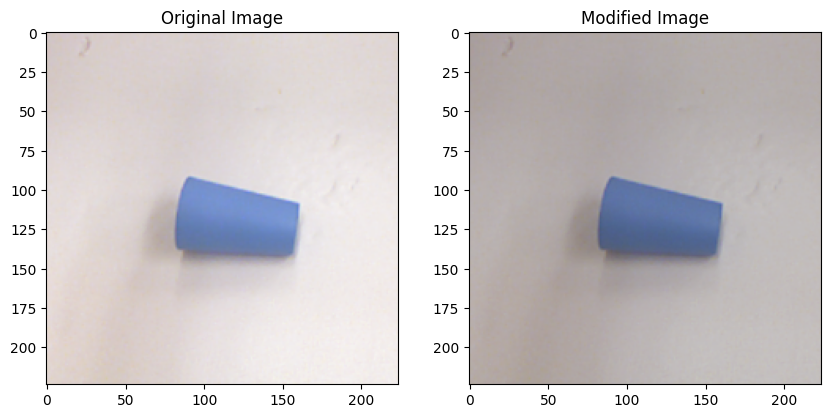

In [ ]:
import cv2
def change_luminosity(img):
    imhsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    factor = np.random.uniform(0.1,1.9)
    mask = imhsv[:,:,2] * factor > 255
    v_channel = np.where(mask, 255, imhsv[:,:,2] * factor)
    imhsv[:,:,2] = v_channel
    return cv2.cvtColor(imhsv,cv2.COLOR_HSV2RGB)

## Test
input_image = X[0]
output_image = change_luminosity(input_image)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(input_image)
axs[0].set_title('Original Image')
axs[1].imshow(output_image)
axs[1].set_title('Modified Image')
plt.show()



### Flip
Flip consists of simply flipping the image up and down or left to right. In this case you must also change the grasping coordinates to Y. The easiest way is to go back to the pixel coordinates with the **grasp2bbox** function. Perform the geometric transformation and then go back to the grasping representation using **bbox2grasp**.

To make flips easily you can use these functions:
`np.fliplr` ot `np.flipud`

Create a flip function which takes as input an image (img) and the grasping parameters (y_list). This function will randomly return the same image, the image flipped left to right or the image flipped top to bottom. Please also change the associated ones.

Write a script to test your function

In [ ]:
def flip(image, y_list):
  img = np.copy(image)
  flipT= np.random.choice(3)

### For flip up and down

  if flipT==0:
    img = np.flipud(img)
    y_list_2=[]
    box_n=[]
    for box in y_list:
        for edges in grasp_to_bbox(box):
          box_n.append([edges[0], 224 - edges[1]])
    box_n = np.array(box_n).reshape(-1,8)
    [y_list_2.append(bboxes_to_grasps(flip_box)) for flip_box in box_n]
    y_list_2 = np.array(y_list_2,dtype=np.float64).reshape(-1,5)

  elif flipT==1:
    img = np.fliplr(img)
    y_list_2=[]
    box_n=[]
    for box in y_list:
        for edges in grasp_to_bbox(box):
          box_n.append([224 - edges[0], edges[1]])
    box_n = np.array(box_n).reshape(-1,8)
    [y_list_2.append(bboxes_to_grasps(flip_box)) for flip_box in box_n]
    y_list_2 = np.array(y_list_2,dtype=np.float64).reshape(-1,5)
  else:
      y_list_2 = y_list

  return img, y_list_2

### The DataGenerator class
We need to create a class which will generate batches of data based on the geometric transformations we have just created. This class will be called dataGenerator and we will give a variable of this class to fit_generator ()

The class must therefore follow a certain format so that Keras understands how to use it. The basic skeleton can be found on this site:
https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly


The skeleton below has been retouched a bit. To create a variable of this class, you must give X and Y data, the desired batch size and indicate whether you want to mix the data or not.

You need to integrate the two functions as an instance of the class and then use them in the instance *__data_generation* to create batches of data as you go.
*__data_generation* should return x and y data in the respective form (batch_size, height, width, 3) and (batch_size, 40, 5).

Here's what you need to do:

* Add your flip and brightness functions to the classroom

* In __data_generation (): fill in to make random transformations to selected X and Y.


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, x, y, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.X = x
        self.Y = y
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.X.shape[0] / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [k for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.X.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def change_luminosity(self,img):
      imhsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
      factor = np.random.uniform(0.1,1.9)
      mask = imhsv[:,:,2] * factor > 255
      v_channel = np.where(mask, 255, imhsv[:,:,2] * factor)
      imhsv[:,:,2] = v_channel
      return cv2.cvtColor(imhsv,cv2.COLOR_HSV2RGB)


    def flip(self,image, y_list):
      img = np.copy(image)
      flipT= np.random.choice(3)

    ### For flip up and down

      if flipT==0:
        img = np.flipud(img)
        y_list_2=[]
        box_n=[]
        for box in y_list:
            for edges in grasp_to_bbox(box):
              box_n.append([edges[0], 224 - edges[1]])
        box_n = np.array(box_n).reshape(-1,8)
        [y_list_2.append(bboxes_to_grasps(flip_box)) for flip_box in box_n]
        y_list_2 = np.array(y_list_2,dtype=float).reshape(-1,5)
    ### For flip right-left
      elif flipT==1:
        img = np.fliplr(img)
        y_list_2=[]
        box_n=[]
        for box in y_list:
            for edges in grasp_to_bbox(box):
              box_n.append([224 - edges[0], edges[1]])
        box_n = np.array(box_n).reshape(-1,8)
        [y_list_2.append(bboxes_to_grasps(flip_box)) for flip_box in box_n]
        y_list_2 = np.array(y_list_2,dtype=float).reshape(-1,5)

      else:
          y_list_2 = y_list

      return img, y_list_2

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.ones((self.batch_size, 224, 224, 3))
        y = 1000 * np.ones((self.batch_size, 100, 5), dtype=float)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            x_temp, y_temp = self.X[ID], self.Y[ID]
            j = np.random.randint(3)
            if j == 3:
              X[i] = self.change_luminosity(x_temp)
              for k in range(len(y_temp)):
                y[i][k] =y_temp[k]
            else:
              X[i],y_temp= self.flip(x_temp,y_temp)
              for k in range(len(y_temp)):
                y[i][k] =y_temp[k]
        return X, y


#### Test: should output : (20, 224, 224, 3) (20, 100, 5)
testing_generator = DataGenerator(X, Y, batch_size=20)
x, y = testing_generator[0]
print(x.shape, y.shape)

(20, 224, 224, 3) (20, 100, 5)


Train a new network with the data generator. Then test its performance

In [ ]:
## Data preparation
X3, Y3 = np.copy(X), np.copy(Y)
# X2, Y2 = preprocess_data_min_mse(X2, Y2)
Y3 = preprocess_data_min_mse(Y3)
x_train3, x_test3, y_train3, y_test3 =train_test_split(X3, Y3,train_size=0.8)

## Creation of the train DataGenerator
training_generator = DataGenerator(x_train3, y_train3, batch_size=100, shuffle=True)

## Training
model_3 = model_2(x_train3)
model_3.fit(training_generator.X, training_generator.Y, epochs=100, validation_data=(x_test3, y_test3))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 110, 110, 96)   │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 55, 55, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 27, 27, 64)     │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 2, 2, 512)      │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 1, 1, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 925,829 (3.53 MB)

 Trainable params: 924,357 (3.53 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 302ms/step - loss: 815445.8750 - val_loss: 55831628.0000
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 314870.5625 - val_loss: 147584032.0000
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 204186.9688 - val_loss: 69688064.0000
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 203303.9219 - val_loss: 15666760.0000
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 160473.9531 - val_loss: 1133187.2500
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 151839.9531 - val_loss: 677215.0625
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 132391.4375 - val_loss: 246831.6875
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 138482.8125 - val_loss: 188870.2812
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 130923.9844 - val_loss: 426396.4688
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 130929.5000 - val_loss: 571189.6875
Epoch 11/100
19/19 ━━━━━━━━

In [ ]:
y_pred3 = model_3.predict(x_test3)
print(y_pred3.shape)
print('Performance of my trained model : {:.1%}'.format(test_performance(y_pred3, y_test3)))

1/5 ━━━━━━━━━━━━━━━━━━━━ 2s 740ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
(150, 5)
Performance of my trained model : 96.7%


In [ ]:
## Save the weights of your model
## To load a previously trained model (that of the final model or that of a checkpoint
model_3.save_weights('model_1.4.weights.h5')
## To load a previously trained model (that of the final model or that of a checkpoint)
model_3.load_weights('model_1.4.weights.h5')